In [348]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
df = pd.read_csv('Datechange_HPIbench.csv')
df=df[['area', 'benchmark_price','property_type', 'Date']]
df['property_type'].unique()

array(['Residential - All Types', 'Detached', 'Townhouse', 'Apartment'],
      dtype=object)

In [349]:
df_Apt=df[(df['area']=='vancouver_east')&(df['property_type']=='Townhouse')]
df_Apt['Date']=pd.to_datetime(df_Apt['Date'], format='%Y-%m')

In [350]:
df_date_index=df_Apt

In [351]:
del(df_date_index['area'])
del(df_date_index['property_type'])
df_east=df_date_index.set_index('Date')

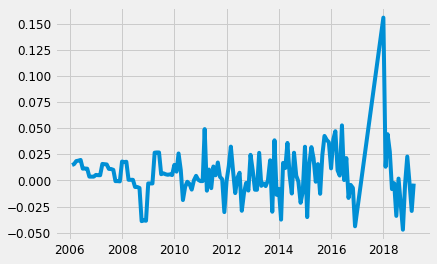

In [352]:
df_date_index= np.log(df_east)
datasetLogDiffShifting = df_date_index - df_date_index.shift()
datasetLogDiffShifting.dropna(inplace=True)
plt.plot(datasetLogDiffShifting)


In [353]:

#dicky fuller test for stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(benchmark_price, window = 12, cutoff = 0.01):
    rolmean = benchmark_price.rolling(window).mean()
    rolstd = benchmark_price.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(benchmark_price, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    X = benchmark_price.values
    result = adfuller(X)
    print('Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

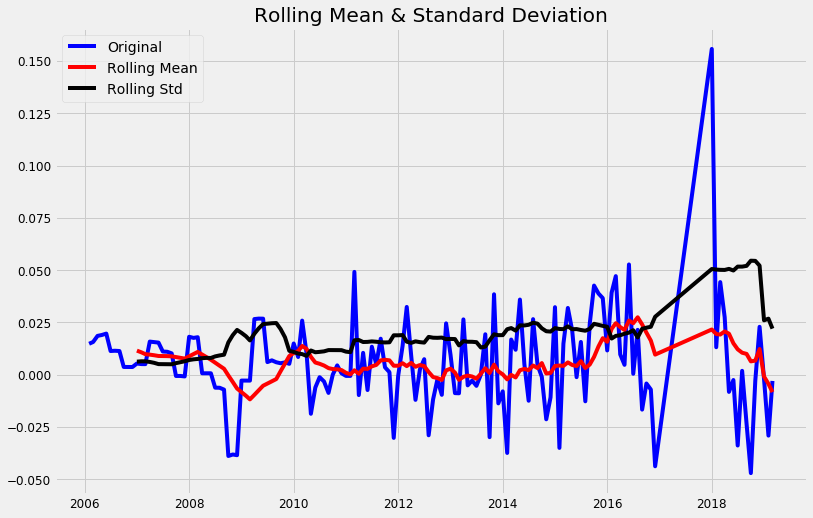

Statistic: -6.697542
p-value: 0.000000
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


In [354]:
test_stationarity(datasetLogDiffShifting['benchmark_price'])


In [355]:

# Get the raw data values from the pandas data frame.
data_raw = datasetLogDiffShifting.values.astype("float32")

# lst rquires 1 to -1, scaling is must
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)



In [356]:
#split into 60 40
train_size = int(len(dataset) * .6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
arr_x=[]
arr_y=[]

In [357]:
def create_dataset(dataset):
    data_X, data_Y = [], []
    for i in range(len(dataset) - 2):
        a = dataset[i:(i + 1), 0]
        data_X.append(a)
        data_Y.append(dataset[i + 1, 0])
    return(np.array(data_X), np.array(data_Y))



In [358]:
train_X, train_Y = create_dataset(train)
test_X, test_Y = create_dataset(test)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))




In [359]:
#fit lstm, 100 epoch, batchsize-1
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)


Epoch 1/100
 - 2s - loss: 0.0414
Epoch 2/100
 - 0s - loss: 0.0114
Epoch 3/100
 - 0s - loss: 0.0053
Epoch 4/100
 - 0s - loss: 0.0048
Epoch 5/100
 - 0s - loss: 0.0048
Epoch 6/100
 - 0s - loss: 0.0048
Epoch 7/100
 - 0s - loss: 0.0048
Epoch 8/100
 - 0s - loss: 0.0048
Epoch 9/100
 - 0s - loss: 0.0048
Epoch 10/100
 - 0s - loss: 0.0047
Epoch 11/100
 - 0s - loss: 0.0047
Epoch 12/100
 - 0s - loss: 0.0047
Epoch 13/100
 - 0s - loss: 0.0047
Epoch 14/100
 - 0s - loss: 0.0047
Epoch 15/100
 - 0s - loss: 0.0046
Epoch 16/100
 - 0s - loss: 0.0046
Epoch 17/100
 - 0s - loss: 0.0047
Epoch 18/100
 - 0s - loss: 0.0046
Epoch 19/100
 - 0s - loss: 0.0047
Epoch 20/100
 - 0s - loss: 0.0046
Epoch 21/100
 - 0s - loss: 0.0047
Epoch 22/100
 - 0s - loss: 0.0046
Epoch 23/100
 - 0s - loss: 0.0046
Epoch 24/100
 - 0s - loss: 0.0046
Epoch 25/100
 - 0s - loss: 0.0045
Epoch 26/100
 - 0s - loss: 0.0045
Epoch 27/100
 - 0s - loss: 0.0046
Epoch 28/100
 - 0s - loss: 0.0047
Epoch 29/100
 - 0s - loss: 0.0045
Epoch 30/100
 - 0s - lo

In [342]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1)
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

In [343]:


import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def predict_and_score(model, X, Y):
   
    prediction_price = scaler.inverse_transform(model.predict(X))
    ground_truth= scaler.inverse_transform([Y])
    score = math.sqrt(mean_squared_error(ground_truth[0], prediction_price [:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)



Training data score: 0.01 RMSE
Test data score: 0.03 RMSE


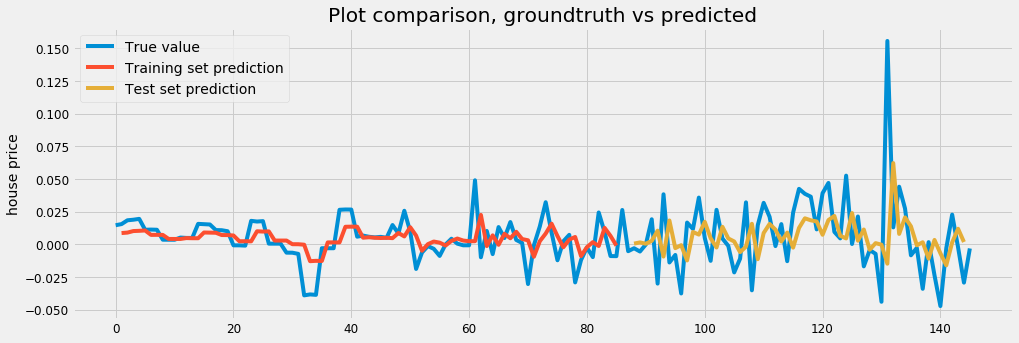

In [344]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.ylabel("house price")
plt.title("Plot comparison, groundtruth vs predicted")
plt.legend()
plt.show()